In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def global_stiffness_matrix(n_nodes, n_spring, stiffness, spring_connection):
  """
    Constructs the global stiffness matrix for a spring system.

    This function assembles a global stiffness matrix based on the spring stiffness
    values and the nodes that each spring connects. The stiffness matrix is used
    in structural analysis to describe how a system resists deformation under external forces.

    Parameters:
    ----------
    n_nodes : int
        The total number of nodes in the system.

    n_spring : int
        The total number of springs in the system.

    stiffness : list of float
        A list containing the stiffness values for each spring. The list should
        have a length equal to `n_spring`.

    spring_connection : dict
        A dictionary where the keys are spring numbers (1-based) and the values
        are lists of two integers `[i, j]`, representing the two nodes that
        each spring connects. For example, `{1: [1, 2], 2: [2, 3], ...}` means
        that spring 1 connects nodes 1 and 2, spring 2 connects nodes 2 and 3, etc.

    Returns:
    -------
    numpy.ndarray
        A square matrix of size `n_nodes x n_nodes` representing the global stiffness matrix
        for the system. The matrix is populated based on the stiffness values of the springs
        and the nodes they connect.
    """
  global_stiff = np.zeros((n_nodes, n_nodes), dtype = float)
  for n in range(n_spring):
    i,j = spring_connection[n+1]
    i = i-1
    j = j-1
    global_stiff[i][i] += stiffness[n]
    global_stiff[j][j] += stiffness[n]
    global_stiff[i][j] -= stiffness[n]
    global_stiff[j][i] -= stiffness[n]

  # print(global_stiff)
  return global_stiff

def flexible_node_position(n_nodes, fixed_node):
    """
    Determines the positions of the flexible (unfixed) nodes in the spring system.

    Given the total number of springs (`n_spring`) and a list of fixed node positions (`fixed_node`),
    this function identifies which nodes are flexible (i.e., not fixed) and returns their positions.

    Parameters:
    ----------
    n_spring : int
        The total number of springs in the system. This is used to determine the number of nodes,
        assuming each spring connects two adjacent nodes.

    fixed_node : list of int
        A list of node positions that are fixed (i.e., the displacement at these nodes is zero).

    Returns:
    -------
    list of int
        A list of the positions of the flexible nodes. The flexible nodes are those that are not in
        the `fixed_node` list. The returned list contains the positions of all nodes that are not fixed.
    """
    # print(n_nodes)
    nodes = [(x+1) for x in range(n_nodes)]
    # print("SPRINGS")
    # print(nodes)
    flexible_node_pos = [x-1 for x in nodes if x not in fixed_node]
    # print(flexible_node_pos)
    return flexible_node_pos

def load_vector(n_nodes, loads):
    """
    Constructs the load vector for the system based on the applied loads.

    Given the total number of nodes (`n_nodes`) and a dictionary of applied loads (`loads`),
    this function creates the corresponding load vector that represents external forces applied
    at specific nodes in the system.

    Parameters:
    ----------
    n_nodes : int
        The total number of nodes in the system. This is used to initialize the load vector,
        which will have the same length as the number of nodes.

    loads : dict
        A dictionary where the keys are node positions (1-based index) and the values are the
        corresponding load values (forces applied at those nodes). For example,
        `{3: 10}` means a load of 10 units is applied at node 3.

    Returns:
    -------
    numpy.ndarray
        A 1D numpy array (load vector) of size `n_nodes` that represents the external forces
        applied at each node. The positions of the applied loads are populated in the load vector,
        and all other nodes have a load of zero.
    """
    # print(f"N_NODES: {n_nodes}")
    # print(f"LOADS: {loads}")
    load_vec = np.zeros((n_nodes), dtype = float)
    load_keys = np.array([int(k) for k in loads.keys()])
    # print(np.array(list(loads.keys())) -1 )
    load_vec[load_keys -1 ] = list(loads.values())
    # print(load_vec)
    return load_vec

def sub_matrix(matrix, pos):
    """
    Extracts a sub-matrix from a given matrix based on specified row and column positions.

    This function returns a sub-matrix formed by selecting specific rows and columns from the
    original matrix. The rows and columns are determined by the indices provided in the `pos` list.

    Parameters:
    ----------
    matrix : numpy.ndarray
      The original 2D matrix (array) from which the sub-matrix will be extracted. It must be a square or rectangular matrix.

    pos : list of int
      A list of indices (0-based) specifying the rows and columns to be selected from the original matrix.
      Both rows and columns of the sub-matrix are chosen based on these indices.

    Returns:
    -------
    numpy.ndarray
      A 2D sub-matrix consisting of the rows and columns specified in `pos`. The dimensions of the
      returned sub-matrix are `len(pos) x len(pos)`.
    """
    # print( matrix[np.ix_(pos, pos)])
    return matrix[np.ix_(pos, pos)]

def displacement(stiffness_matrix, load_vector):
    """
    Solves for the displacement vector of a system based on the stiffness matrix and load vector.

    This function calculates the displacement at each node in a structural system using the
    finite element method. The displacement is obtained by solving the equation:
    `displacement = inv(stiffness_matrix) * load_vector`,
    where `stiffness_matrix` is the global stiffness matrix and `load_vector` is the load vector applied to the system.

    Parameters:
    ----------
    stiffness_matrix : numpy.ndarray
        A square matrix (2D array) representing the global stiffness matrix of the system. The matrix should
        have dimensions `n_nodes x n_nodes`, where `n_nodes` is the total number of nodes in the system.

    load_vector : numpy.ndarray
        A vector (1D array) representing the applied loads at the nodes. The size of the vector should be
        `n_nodes`, matching the number of nodes in the system.

    Returns:
    -------
    numpy.ndarray
        A vector (1D array) of size `n_nodes`, representing the displacements at the nodes of the system.
        The displacement values are computed by solving the equation: `displacement = inv(stiff) * load`.
    """
    inv_stiff = np.linalg.inv(stiffness_matrix)
    return np.matmul(inv_stiff, load_vector)

def reaction_force(global_stiffness, disp_vector, fixed_node):
    """
    Computes the reaction forces at the fixed nodes of the system.

    This function calculates the reaction forces at the fixed nodes of a system based on the
    global stiffness matrix and the displacement vector. The reaction force is computed using
    the equation: `reaction_force = global_stiffness * displacement_vector` for each fixed node.

    Parameters:
    ----------
    global_stiffness : numpy.ndarray
        A 2D numpy array representing the global stiffness matrix of the system, which is of size
        `n_nodes x n_nodes`, where `n_nodes` is the number of nodes in the system.

    disp_vector : numpy.ndarray
        A 1D numpy array of size `n_nodes`, representing the displacement vector for the system.
        Each element corresponds to the displacement at each node.

    fixed_node : list of int
        A list of node indices (1-based) where the displacement is fixed (i.e., zero displacement).
        These nodes will have reaction forces computed based on their fixed displacement conditions.

    Returns:
    -------
    list of float
        A list containing the reaction forces at the fixed nodes. Each entry corresponds to the
        reaction force calculated for each fixed node based on its displacement.
    """
    reaction_force = []
    for i in fixed_node:
      pos = i-1
      reaction_force.append(round(np.matmul(global_stiffness[pos],disp_vector),2))
    return reaction_force

def spring_force(spring_connection, spring_stiffness, disp_vector):
    """
    Computes the force in each spring based on the displacement vector.

    This function calculates the force exerted by each spring in a spring system. The force in
    a spring is computed using Hooke's Law, which relates the spring force to the displacement
    between the nodes connected by the spring. The formula is:

    `spring_force = spring_stiffness * (displacement[j] - displacement[i])`

    where `i` and `j` are the node indices connected by the spring, and `disp_vector[i]` and
    `disp_vector[j]` are the displacements at those nodes.

    Parameters:
    ----------
    spring_stiffness : list of float
        A list of spring stiffness values. Each value represents the stiffness of a spring
        in the system. The list must have the same length as the number of springs.

    disp_vector : numpy.ndarray
        A 1D numpy array representing the displacement vector of the system. The displacement
        at each node is given in this vector.

    Returns:
    -------
    list of float
        A list containing the forces in each spring. The force in the `n`-th spring is calculated
        based on the displacement of the nodes it connects and the spring's stiffness.
    """
    spring_force = []
    for n in range(len(spring_stiffness)):
      spring_no = list(spring_connection.keys())[n]
      i,j = spring_connection[spring_no]
      i = i-1
      j = j-1
      # print("___________")
      # print(spring_stiffness[n])
      # print(disp_vector[j])
      # print(disp_vector[i])
      # print("____________")
      spring_force.append(round(spring_stiffness[n] * (disp_vector[j] - disp_vector[i]), 2 ))
    return spring_force


def solve_problem(n_nodes, n_spring, stiffness, spring_connection, loads, fixed_node):
    """
    Solves a structural mechanics problem by calculating the displacement, reaction forces,
    and spring forces for a system of springs with given stiffness and loading conditions.

    The function performs the following steps:
    1. Constructs the global stiffness matrix based on the spring stiffness and node connections.
    2. Constructs the load vector based on applied loads at specific nodes.
    3. Identifies the flexible nodes and calculates the displacement of these nodes.
    4. Computes the reaction forces at the fixed nodes using the displacement results.
    5. Calculates the spring forces based on the displacement vector.

    Parameters:
    ----------
    n_nodes : int
        The total number of nodes in the system. This should be the size of the displacement vector.

    n_spring : int
        The total number of springs in the system. This should match the length of the spring stiffness array.

    stiffness : list of float
        A list of spring stiffness values. Each value corresponds to the stiffness of a spring in the system.

    spring_connection : dict
        A dictionary mapping each spring number (key) to the nodes it connects (value).
        The nodes are specified by 1-based indices.

    loads : dict
        A dictionary mapping node indices (1-based) to applied loads. The load at each node is specified in this dictionary.

    fixed_node : list of int
        A list of node indices (1-based) where the displacement is fixed (i.e., no displacement at these nodes).
        These nodes are treated as boundary conditions in the problem.

    Returns:
    -------
    list
        A list containing:
        - `disp_vector` (numpy.ndarray): The displacement vector for each node in the system.
        - `reaction_forces` (list of float): The reaction forces at the fixed nodes.
        - `spring_forces` (list of float): The forces in each spring, calculated based on the displacements.
    """

    disp_vector = np.zeros(n_nodes, dtype = float)

    global_stiff = global_stiffness_matrix(n_nodes, n_spring,stiffness, spring_connection)
    load_vec = load_vector(n_nodes, loads)

    flexible_node_pos = flexible_node_position(n_nodes, fixed_node)

    sub_global_stiff = sub_matrix(global_stiff, flexible_node_pos)
    sub_load_vec = load_vec[flexible_node_pos]

    disp = displacement(sub_global_stiff, sub_load_vec)
    disp_vector[flexible_node_pos] = disp

    reaction_forces = reaction_force(global_stiff, disp_vector, fixed_node)
    spring_forces = spring_force(spring_connection, stiffness, disp_vector)

    return [disp_vector, reaction_forces, spring_forces]

def area(Diameter):
  """
    Calculates the cross-sectional area of circular bars based on their diameters.

    This function computes the area of a circle for each diameter provided using the formula:
    A = (π * d^2) / 4, where d is the diameter of the circle.

    Parameters:
    ----------
    Diameter : list of float
        A list of diameters of the circular bars for which the area needs to be calculated.

    Returns:
    -------
    list of float
        A list containing the calculated areas for each diameter in the input list.
  """
  area = []
  for dia in Diameter:
    area.append((np.pi * dia ** 2)/4)
  return area

def sqr_area(Height):
  """
    Calculates the area of square bars based on their side lengths.

    This function computes the area of a square for each side length provided using the formula:
    A = h^2, where h is the length of one side of the square.

    Parameters:
    ----------
    Height : list of float
        A list of side lengths of the square bars for which the area needs to be calculated.

    Returns:
    -------
    list of float
        A list containing the calculated areas for each side length in the input list.
  """
  area = []
  for height in Height:
    # print(height)
    area.append(height * height)
  return area


def bar_stiffness(length, area, modulus):
  """
    Calculates the stiffness of bars based on their length, cross-sectional area, and Young's modulus.

    This function computes the stiffness of a bar using the formula:
    k = (A * E) / L, where:
    - A is the cross-sectional area of the bar,
    - E is the Young's modulus of the material,
    - L is the length of the bar.

    Parameters:
    ----------
    length : list of float
        A list of lengths of the bars for which stiffness needs to be calculated.

    area : list of float
        A list of cross-sectional areas of the bars.

    modulus : list of float
        A list of Young's modulus values (material stiffness) corresponding to each bar.

    Returns:
    -------
    list of float
        A list containing the calculated stiffness values for each bar.
  """

  stiffness = []
  # print(f'length: {length}')
  # print(f'area: {area}')
  # print(f'modulus: {modulus}')
  for i in range(len(length)):
    stiffness.append(area[i]*modulus[i]/length[i])
  # print(stiffness)
  return stiffness

def bar_connection(n_bars):
  """
    Creates a dictionary that maps each bar to its connected nodes.

    This function assumes a linear bar connection, where each bar connects two consecutive nodes.
    The dictionary will map each bar number to a list of two nodes (start and end) that the bar connects.

    Parameters:
    ----------
    n_bars : int
        The total number of bars in the system.

    Returns:
    -------
    dict
        A dictionary where each key is a bar number (1-based index) and the value is a list containing
        the two nodes that the bar connects.
  """

  connection = {}
  for i in range(n_bars):
    connection[i+1] = [i+1, i+2]
  return connection

def bar_nodes(n_bar):
  """
    Calculates the total number of nodes in the system based on the number of bars.

    The function assumes a linear bar connection where each bar connects two consecutive nodes.
    The total number of nodes will be one more than the number of bars.

    Parameters:
    ----------
    n_bar : int
        The total number of bars in the system.

    Returns:
    -------
    int
        The total number of nodes, which is the number of bars plus one.
  """
  return n_bar+1

def solve_bar(n_bars, bar_length, bar_diameter, bar_modulus, loads, fixed_node, mode):
  """
    Solves the structural mechanics problem for a system of bars and calculates the displacement,
    reaction forces, and spring forces based on the provided parameters.

    This function computes the stiffness of the bars based on either circular or square cross-sections
    and solves for the displacements, reaction forces, and spring forces. It uses the bar stiffness and
    the bar connection to model the system, and it applies loads and boundary conditions at the specified
    nodes.

    Parameters:
    ----------
    n_bars : int
        The total number of bars in the system.

    bar_length : list of float
        A list containing the lengths of each bar in the system.

    bar_diameter : list of float
        A list containing the diameters (or side lengths for square bars) of each bar.

    bar_modulus : list of float
        A list containing the Young's modulus values (material stiffness) for each bar.

    loads : dict
        A dictionary mapping node indices (1-based) to applied loads at those nodes.

    fixed_node : list of int
        A list of node indices (1-based) where displacement is fixed (boundary conditions).

    mode : int
        A flag to specify the type of cross-section:
        - 0 for circular cross-section (using diameter),
        - 1 for square cross-section (using side length).

    Returns:
    -------
    list
        A list containing:
        - `disp_vector` (numpy.ndarray): The displacement vector for each node in the system.
        - `reaction_force` (list of float): The reaction forces at the fixed nodes.
        - `spring_force` (list of float): The forces in each bar, calculated based on the displacements.
  """

  connection = bar_connection(n_bars)
  # print(connection)
  if (mode == 0):
    stiffness = bar_stiffness(bar_length, area(bar_diameter), bar_modulus )
  else:
    # print('square')
    stiffness = bar_stiffness(bar_length, sqr_area(bar_diameter), bar_modulus )
  # print(stiffness)
  # for i in range(n_bars):
  #   stiffness.append(bar_stiffness(bar_length[i], area(bar_diameter[i]), bar_modulus[i]))
  n_nodes = bar_nodes(n_bars)
  # print(n_nodes)
  disp_vector, reaction_force, spring_force = solve_problem(n_nodes, n_bars, stiffness, connection, loads, fixed_node)
  return [disp_vector, reaction_force, spring_force ]


def load_node(length, loaded_length, elements):
  """
    Identifies the nodes that are loaded based on the total length of the bar,
    the loaded length, and the number of elements in the system.

    This function divides the total bar length into equal increments (based on the number of elements),
    and it identifies the specific nodes that fall within the loaded length range.

    Parameters:
    ----------
    length : float
        The total length of the bar.

    loaded_length : list of float
        A list of specific positions along the bar where the load is applied.

    elements : int
        The total number of elements into which the bar is divided.

    Returns:
    -------
    list of float
        A list of the node indices that are located at the loaded positions along the bar.
  """
  increment = length / elements
  node_length = ([(i)*increment for i in range(elements + 1)])
  load_node = [(x/increment) for x in node_length if x in loaded_length]
  return load_node

def load_dict(load_node, loads):
  """
    Creates a dictionary mapping load node indices to the corresponding load values.

    This function takes a list of nodes where loads are applied (`load_node`) and a dictionary of
    load values (`loads`) and creates a new dictionary mapping each load node index to its corresponding load value.

    Parameters:
    ----------
    load_node : list of int
        A list of node indices where loads are applied.

    loads : dict
        A dictionary where keys represent the load values and values represent the applied loads at the nodes.

    Returns:
    -------
    dict
        A dictionary where keys are the load node indices (1-based) and values are the corresponding load values.
  """
  load_dict_ = {}
  for i in range(len(loads)):
    load_dict_[load_node[i]+1] = list(loads.values())[i]
  return load_dict_


def element_bar_length(length, elements):
  """
    Calculates the length of each bar element by dividing the total length by the number of elements.

    This function assumes that the total bar length is evenly divided into smaller elements. It returns
    a list of the same length for each element.

    Parameters:
    ----------
    length : float
        The total length of the bar.

    elements : int
        The total number of elements the bar is divided into.

    Returns:
    -------
    list of float
        A list containing the length of each bar element.
  """
  bar_length = [length/elements for i in range(elements)]
  return bar_length

def element_bar_height(height_left, height_right, length, elements):
  """
    Calculates the height of each bar element, assuming a linear variation in height.

    The function calculates the height for each element along the bar based on the initial height at the left
    end (`height_left`) and the final height at the right end (`height_right`). It assumes a linear change in height
    across the elements.

    Parameters:
    ----------
    height_left : float
        The height at the left end of the bar.

    height_right : float
        The height at the right end of the bar.

    length : float
        The total length of the bar.

    elements : int
        The number of elements the bar is divided into.

    Returns:
    -------
    list of float
        A list containing the height at each element along the bar.
  """
  height = []
  current = height_left
  diff = height_left - height_right
  for i in range(elements):
    height.append(current - (diff/(elements*2)))
    current -= diff/elements
  return height

def element_bar_modulus(bar_modulus, elements):
  """
    Creates a list of identical material modulus values for each bar element.

    This function takes the material modulus for the entire bar and replicates it for each of the elements
    in the bar.

    Parameters:
    ----------
    bar_modulus : float
        The Young's modulus (material stiffness) for the bar material.

    elements : int
        The number of elements the bar is divided into.

    Returns:
    -------
    list of float
        A list containing the material modulus value for each bar element.
  """

  bar_modulus = [bar_modulus for i in range(elements)]
  return bar_modulus

def element_fixed_node(elements):
  """
    Identifies the fixed nodes at the ends of the bar.

    This function assumes that the first and last nodes of the bar are fixed. It returns a list of these two
    fixed node indices, where node 1 is fixed at the left end and node `elements + 1` is fixed at the right end.

    Parameters:
    ----------
    elements : int
        The total number of elements in the bar.

    Returns:
    -------
    list of int
        A list containing the fixed node indices (1-based) at the two ends of the bar.
  """
  return [1,elements+1]


def solve_fem_bar(length, height_left, height_right, loaded_length, bar_modulus, elements, mode, fixed):
  """
    Solves a finite element model (FEM) problem for a bar and calculates the displacement, reaction forces,
    and spring forces using the given material properties and loading conditions.

    This function divides the bar into smaller elements, computes the necessary properties for each element
    (length, height, modulus), and uses FEM analysis to solve for the displacements, reaction forces,
    and spring forces. It applies loads at specific nodes and assumes boundary conditions at the fixed nodes.

    Parameters:
    ----------
    length : float
        The total length of the bar.

    height_left : float
        The height (or displacement) at the left end of the bar.

    height_right : float
        The height (or displacement) at the right end of the bar.

    loaded_length : list of float
        A list of positions along the bar where loads are applied.

    bar_modulus : float
        The material modulus (Young's modulus) for the bar.

    elements : int
        The number of elements the bar is divided into for FEM analysis.

    mode : int
        A flag that indicates the type of cross-section used for the bar:
        - 0 for circular cross-section (using diameter),
        - 1 for square cross-section (using side length).

    fixed : int
    A flag that indicates the type of bar fixture:
    - 0 for fix on one end,
    - 1 for fix on both end.

    Returns:
    -------
    list
        A list containing:
        - `disp_vector` (numpy.ndarray): The displacement vector for each node in the system.
        - `reaction_forces` (list of float): The reaction forces at the fixed nodes.
        - `spring_forces` (list of float): The forces in each bar element based on the displacements.
  """
  bar_length = element_bar_length(length, elements)
  bar_height = element_bar_height(height_left, height_right, length, elements)
  load_nodes = load_node(length, loaded_length, elements)
  load_dicts = load_dict(load_nodes, loads)
  bar_modul = element_bar_modulus(bar_modulus, elements)
  if (fixed == 1):
    fixed_node = element_fixed_node(elements)
  else:
    fixed_node = [1]
  # print(load_dicts)
  disp_vector, reaction_forces, spring_forces = solve_bar(elements, bar_length, bar_height, bar_modul, load_dicts, fixed_node, mode)
  return [disp_vector, reaction_forces, spring_forces]

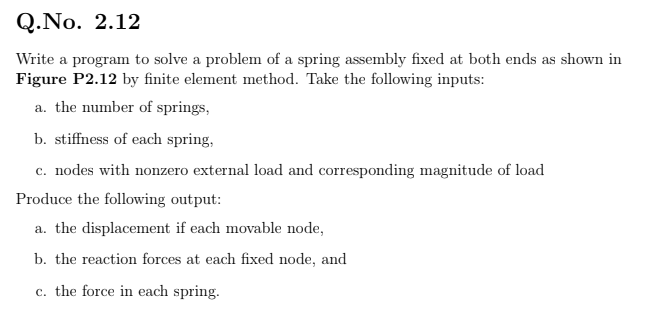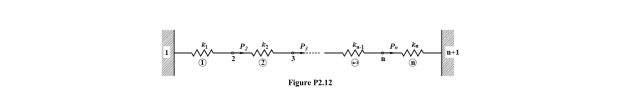

In [ ]:
# Number of springs and nodes
n_spring = int(input("Enter the number of springs: "))
n_nodes = int(input("Enter the number of nodes: "))

# Spring stiffness values
stiffness = []
for i in range(n_spring):
    stiff_value = int(input(f"Enter stiffness value for spring {i+1} (stiff[{i}]): "))
    stiffness.append(stiff_value)

# Spring connections (node pairs)
spring_connection = {}
for i in range(n_spring):
    nodes_input = input(f"Enter the nodes connected by spring {i+1} (comma-separated, e.g. 1,2): ")
    spring_connection[i+1] = list(map(int, nodes_input.split(',')))

# Nodes where loads are applied
nodes_input = input("Enter the node(s) where the load is applied (comma-separated, e.g. 3,4): ")
nodes = list(map(int, nodes_input.split(',')))

# Load values corresponding to the nodes
load = []
for i in range(len(nodes)):
    load_value = int(input(f"Enter load value for node {nodes[i]}: "))
    load.append(load_value)

# Create load dictionary
loads = {}
for i in range(len(nodes)):
    loads[nodes[i]] = load[i]

# Fixed nodes
fixed_nodes_input = input("Enter the fixed node(s) (comma-separated, e.g. 1,5): ")
fixed_node = list(map(int, fixed_nodes_input.split(',')))

Enter the number of springs: 4
Enter the number of nodes: 5
Enter stiffness value for spring 1 (stiff[0]): 1000
Enter stiffness value for spring 2 (stiff[1]): 2000
Enter stiffness value for spring 3 (stiff[2]): 3000
Enter stiffness value for spring 4 (stiff[3]): 1500
Enter the nodes connected by spring 1 (comma-separated, e.g. 1,2): 1,2
Enter the nodes connected by spring 2 (comma-separated, e.g. 1,2): 2,3
Enter the nodes connected by spring 3 (comma-separated, e.g. 1,2): 3,4
Enter the nodes connected by spring 4 (comma-separated, e.g. 1,2): 4,5
Enter the node(s) where the load is applied (comma-separated, e.g. 3,4): 3
Enter load value for node 3: 1000
Enter the fixed node(s) (comma-separated, e.g. 1,5): 1,5


In [ ]:
disp_vector, reaction_forces, spring_forces = solve_problem(n_nodes, n_spring, stiffness, spring_connection, loads, fixed_node)

In [ ]:
disp_vector

array([0. , 0.4, 0.6, 0.4, 0. ])

In [ ]:
reaction_forces

[-400.0, -600.0]

In [ ]:
spring_forces

[400.0, 400.0, -600.0, -600.0]

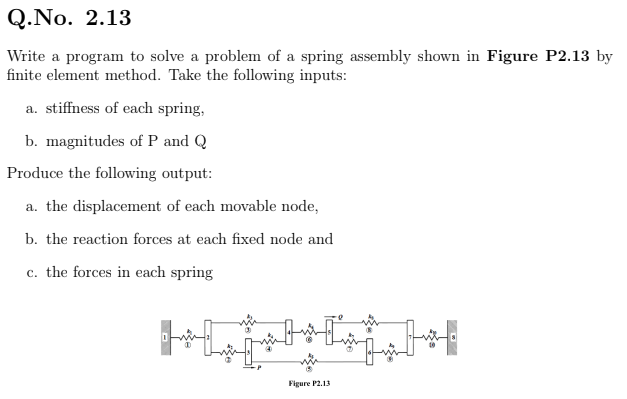

In [ ]:
# Number of springs and nodes
n_spring = int(input("Enter the number of springs: "))
n_nodes = int(input("Enter the number of nodes: "))

# Spring stiffness values
stiffness = []
for i in range(n_spring):
    stiff_value = int(input(f"Enter stiffness value for spring {i+1} (stiff[{i}]): "))
    stiffness.append(stiff_value)

# Spring connections (node pairs)
spring_connection = {}
for i in range(n_spring):
    nodes_input = input(f"Enter the nodes connected by spring {i+1} (comma-separated, e.g. 1,2): ")
    spring_connection[i+1] = list(map(int, nodes_input.split(',')))

# Nodes where loads are applied
nodes_input = input("Enter the node(s) where the load is applied (comma-separated, e.g. 3,4): ")
nodes = list(map(int, nodes_input.split(',')))

# Load values corresponding to the nodes
load = []
for i in range(len(nodes)):
    load_value = int(input(f"Enter load value for node {nodes[i]}: "))
    load.append(load_value)

# Create load dictionary
loads = {}
for i in range(len(nodes)):
    loads[nodes[i]] = load[i]

# Fixed nodes
fixed_nodes_input = input("Enter the fixed node(s) (comma-separated, e.g. 1,5): ")
fixed_node = list(map(int, fixed_nodes_input.split(',')))

Enter the number of springs: 10
Enter the number of nodes: 8
Enter stiffness value for spring 1 (stiff[0]): 100
Enter stiffness value for spring 2 (stiff[1]): 100
Enter stiffness value for spring 3 (stiff[2]): 100
Enter stiffness value for spring 4 (stiff[3]): 100
Enter stiffness value for spring 5 (stiff[4]): 100
Enter stiffness value for spring 6 (stiff[5]): 100
Enter stiffness value for spring 7 (stiff[6]): 100
Enter stiffness value for spring 8 (stiff[7]): 100
Enter stiffness value for spring 9 (stiff[8]): 100
Enter stiffness value for spring 10 (stiff[9]): 100
Enter the nodes connected by spring 1 (comma-separated, e.g. 1,2): 1,2
Enter the nodes connected by spring 2 (comma-separated, e.g. 1,2): 2,3
Enter the nodes connected by spring 3 (comma-separated, e.g. 1,2): 2,4
Enter the nodes connected by spring 4 (comma-separated, e.g. 1,2): 3,4
Enter the nodes connected by spring 5 (comma-separated, e.g. 1,2): 3,6
Enter the nodes connected by spring 6 (comma-separated, e.g. 1,2): 4,5
En

In [ ]:
disp_vector, reaction_force, spring_force = solve_problem(n_nodes, n_spring, stiffness, spring_connection, loads, fixed_node)

In [ ]:
disp_vector

array([0. , 2. , 3.2, 2.8, 3.2, 2.8, 2. , 0. ])

In [ ]:
reaction_force

[-200.0, -200.0]

In [ ]:
spring_force

[200.0, 120.0, 80.0, -40.0, -40.0, 40.0, -40.0, -120.0, -80.0, -200.0]

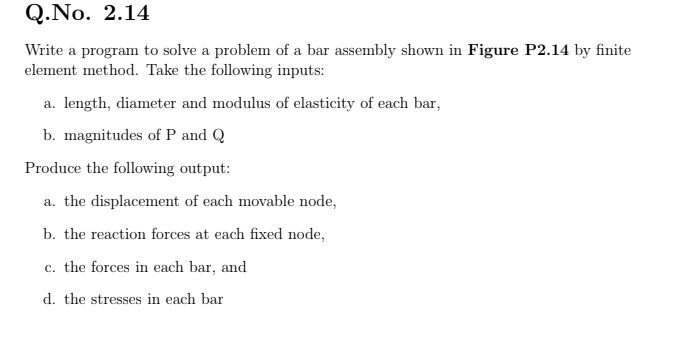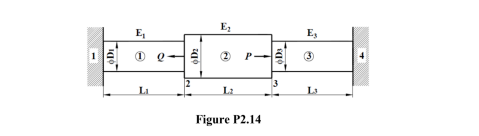

In [ ]:
# Number of bars
n_bars = int(input("Enter the number of bars: "))

bar_length = []
bar_diameter = []
bar_modulus = []

for n in range(n_bars):
  length = int(input(f"Enter length for bar {n+1}: "))
  bar_length.append(length)

for n in range(n_bars):
  dia = int(input(f"Enter diameter for bar {n+1}: "))
  bar_diameter.append(dia)

for n in range(n_bars):
  modulus = int(input(f"Enter modulus of elasticity for spring {n+1}: "))
  bar_modulus.append(modulus)

# Nodes where loads are applied
nodes_input = input("Enter the node(s) where the load is applied (comma-separated, e.g. 3,4): ")
nodes = list(map(int, nodes_input.split(',')))

# Load values corresponding to the nodes
load = []
for i in range(len(nodes)):
    load_value = int(input(f"Enter load value for node {nodes[i]}: "))
    load.append(load_value)

# Create load dictionary
loads = {}
for i in range(len(nodes)):
    loads[nodes[i]] = load[i]

# Fixed nodes
fixed_nodes_input = input("Enter the fixed node(s) (comma-separated, e.g. 1,5): ")
fixed_node = list(map(int, fixed_nodes_input.split(',')))

Enter the number of bars: 3
Enter length for bar 1: 120
Enter length for bar 2: 150
Enter length for bar 3: 120
Enter diameter for bar 1: 20
Enter diameter for bar 2: 30
Enter diameter for bar 3: 20
Enter modulus of elasticity for spring 1: 200
Enter modulus of elasticity for spring 2: 200
Enter modulus of elasticity for spring 3: 200
Enter the node(s) where the load is applied (comma-separated, e.g. 3,4): 2,3
Enter load value for node 2: 1500
Enter load value for node 3: 2000
Enter the fixed node(s) (comma-separated, e.g. 1,5): 1,4


In [ ]:
disp_vector, reaction_forces, spring_forces = solve_bar(n_bars, bar_length, bar_diameter, bar_modulus, loads, fixed_node, 0)

In [ ]:
disp_vector

array([0.        , 3.2384571 , 3.44605051, 0.        ])

In [ ]:
reaction_forces

[-1695.65, -1804.35]

In [ ]:
spring_forces

[1695.65, 195.65, -1804.35]

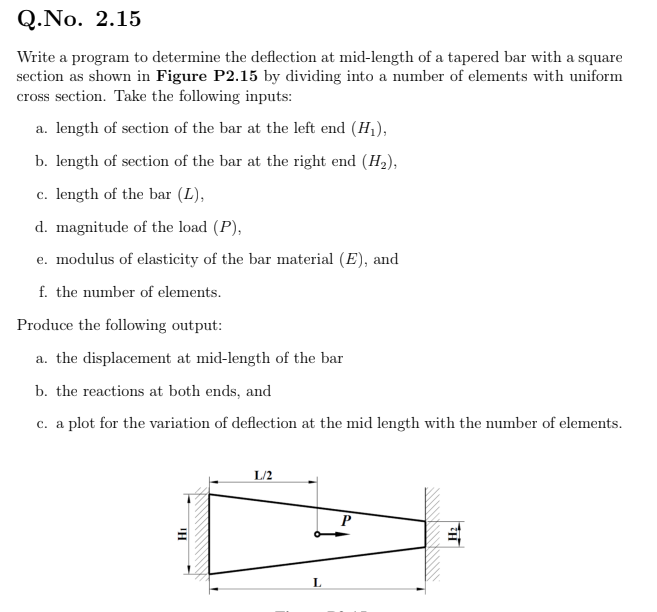

In [ ]:
length = int(input(f"Enter length for bar: "))

height_left = int(input(f"Enter height for left end of the bar: "))
height_right = int(input(f"Enter height for right end of the bar: "))

modulus = int(input(f"Enter modulus of elasticity for the bar: "))

# Nodes where loads are applied
load_length = input("Enter the length where the load is applied (comma-separated, e.g. 3,4): ")
loaded_length = list(map(float, load_length.split(',')))

# Load values corresponding to the nodes
load = []
for i in range(len(loaded_length)):
    load_value = int(input(f"Enter load value for length {loaded_length[i]}: "))
    load.append(load_value)

# Create load dictionary
loads = {}
for i in range(len(loaded_length)):
    loads[loaded_length[i]] = load[i]

# Fixed nodes
fixed_length_pos = [0,length]

elements = int(input(f"Enter the number of elements: "))

Enter length for bar: 2
Enter height for left end of the bar: 2
Enter height for right end of the bar: 1
Enter modulus of elasticity for the bar: 200
Enter the length where the load is applied (comma-separated, e.g. 3,4): 1
Enter load value for length 1.0: 1000
Enter the number of elements: 2


In [ ]:
mode = 1 #1 for square, 0 for circular bar
both_fix = 1
disp = []
elem=[]
for elements in range(2,40,2):
  disp_vector, reaction_forces, spring_forces = solve_fem_bar(length, height_left, height_right, loaded_length, modulus,elements, mode, both_fix)
  mid = len(disp_vector)//2
  elem.append(elements)
  disp.append(disp_vector[mid])

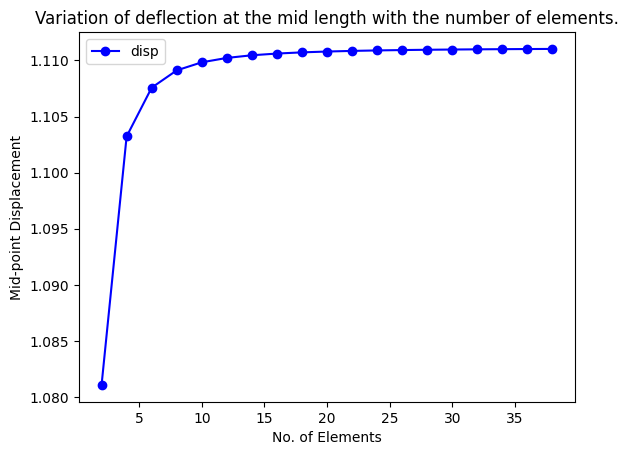

In [ ]:

plt.plot(elem, disp, label='disp', color='b', marker='o')

plt.xlabel('No. of Elements')
plt.ylabel('Mid-point Displacement')
plt.title('Variation of deflection at the mid length with the number of elements.')

plt.legend()
plt.show()

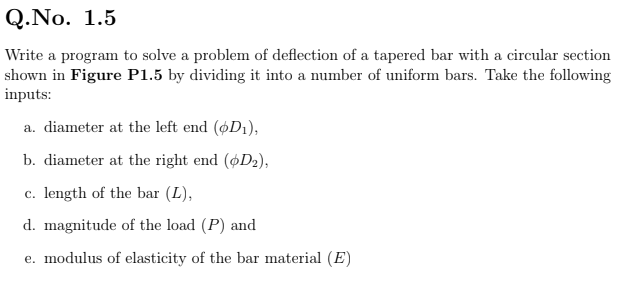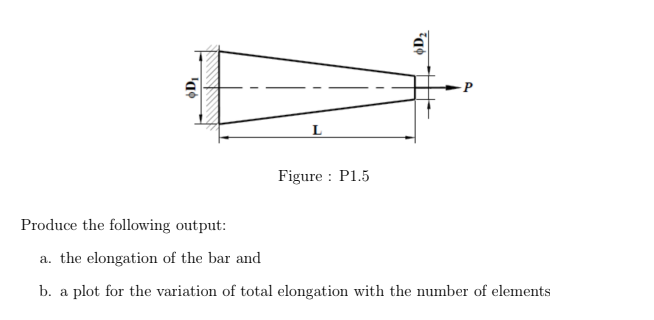

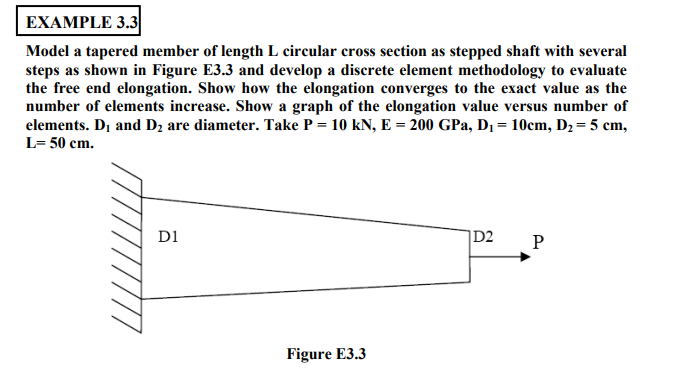v

In [ ]:
length = float(input(f"Enter length for bar: "))

height_left = float(input(f"Enter height for left end of the bar: "))
height_right = float(input(f"Enter height for right end of the bar: "))

modulus = float(input(f"Enter modulus of elasticity for the bar: "))

# Nodes where loads are applied
load_length = input("Enter the length where the load is applied (comma-separated, e.g. 3,4): ")
loaded_length = list(map(float, load_length.split(',')))

# Load values corresponding to the nodes
load = []
for i in range(len(loaded_length)):
    load_value = float(input(f"Enter load value for length {loaded_length[i]}: "))
    load.append(load_value)

# Create load dictionary
loads = {}
for i in range(len(loaded_length)):
    loads[loaded_length[i]] = load[i]

# Fixed nodes
fixed_length_pos = [0,length]

elements = int(input(f"Enter the number of elements: "))

Enter length for bar: 0.5
Enter height for left end of the bar: 0.1
Enter height for right end of the bar: 0.05
Enter modulus of elasticity for the bar: 200e09
Enter the length where the load is applied (comma-separated, e.g. 3,4): 0.5
Enter load value for length 0.5: 10000
Enter the number of elements: 2


In [ ]:
disp_vect, reaction_forces, spring_forces = solve_fem_bar(length, height_left, height_right, loaded_length, modulus,elements, 0, 0)

In [ ]:
disp_vect

array([0.00000000e+00, 2.07875844e-06, 6.15312498e-06])

In [ ]:
reaction_forces

[-10000.0]

In [ ]:
spring_forces

[10000.0, 10000.0]

In [ ]:
mode = 0 #1 for square, 0 for circular bar
left_fix = 0
disp = []
elem=[]
for elements in range(2,40):
  disp_vector, reaction_forces, spring_forces = solve_fem_bar(length, height_left, height_right, loaded_length, modulus,elements, mode, left_fix)
  end = len(disp_vector)
  elem.append(elements)
  disp.append(disp_vector[end-1])

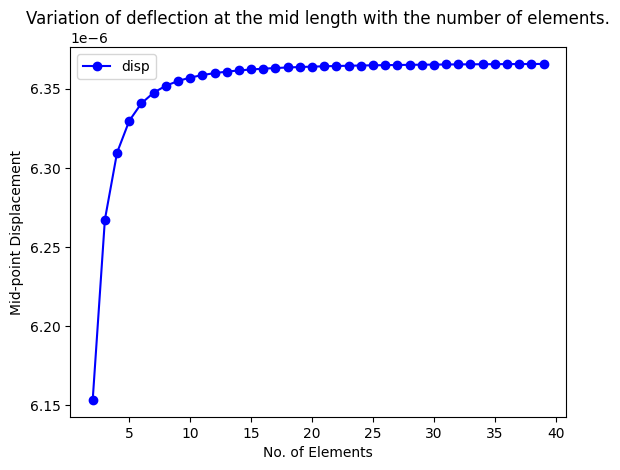

In [ ]:

plt.plot(elem, disp, label='disp', color='b', marker='o')

plt.xlabel('No. of Elements')
plt.ylabel('Mid-point Displacement')
plt.title('Variation of deflection at the end with the number of elements.')

plt.legend()
plt.show()

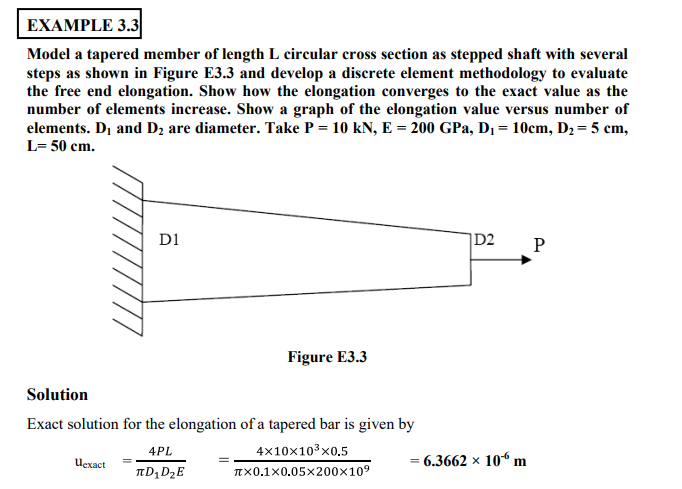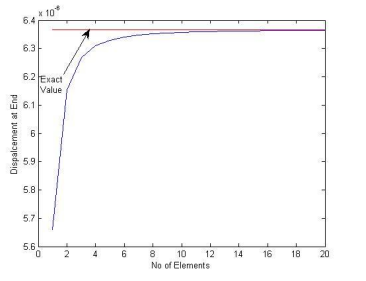